In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.insert(0, '../')
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,TensorBoard, Callback
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from common import util
from sklearn.model_selection import train_test_split
import random
import glob
import tensorflow as tf
K.set_image_dim_ordering('th')

/usr/local/lib/python2.7/dist-packages/dlutils/plot_image_batch_w_labels.py:16: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/

In [98]:
def hot_vectorize(x,value = 0):
    zero_mask = x==value
    non_zero_mask = x!=value
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x.astype(float)

def stack_frames(frames,img_height,img_width,channels):
    stack  = np.zeros((1,img_height,img_width,channels))
    index = 0
    for i in frames:
        num_chan = 1 if len(np.shape(i)) ==2 else np.shape(i)[2]
        stack[0,:,:,index:index+num_chan] = np.reshape(i,(img_height,img_width,num_chan))
        index += num_chan
    return stack

def grab_frame(files,i,path,func=None):
    img = misc.imread(path+files[i])
    if func:
        return func(img)
    return img

def grab_frame1(path,func=None):
    img = misc.imread(path)
    if func:
        return func(img)
    return img

def normalize(x):
    return x.astype(float)/3500.

def normalize_depth(x):
    return x.astype(float)/3000.

def convert_rgb_normal(img):
    return (img/255.*2)-1

def bounding_box(img,size = 100):
    h,w = np.shape(img)
    non_zeros = np.nonzero(img)
    x_min = np.min(non_zeros[0])
    x_max = np.max(non_zeros[0])
    y_min = np.min(non_zeros[1])
    y_max = np.max(non_zeros[1])
    out = (x_min,x_min+size,y_min,y_min+size) if size else (x_min,x_max,y_min,y_max)#minuce or plus coordinates
    if x_min< 0 or x_min+size > h or y_min<0 or y_min+size>w:
        return None
    return out

In [274]:
samples[len(samples)/2]

('/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-06-16-58/0000001777_2017-06-16-58_depth_ground_truth.png',
 '/media/drc/DATA/chris_labelfusion/RGBDCNN/2017-06-16-58/0000001777_depth.png')

In [270]:
samples = gen_samples("/media/drc/DATA/chris_labelfusion/RGBDCNN/",False)

In [112]:
train = generate_data_custom_depth(samples)

In [69]:
def gen_samples(directory,shuffle = True):
    samples = []
    dirs = os.listdir(directory)
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            gt_depth = sorted(glob.glob(path+"*_truth.png"))
            depth = sorted(glob.glob(path+"*_depth.png"))
            samples.extend(zip(gt_depth,depth))
    if shuffle:
        random.shuffle(samples)
    return samples                

In [111]:
def generate_data_custom_depth(samples,img_height=480,img_width=640,batch_size=8):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,1))
        stack2 = np.zeros((batch_size,img_height,img_width,1))
        j=0
        while j<batch_size:
            try:
                rgb = samples[i][0]
                depth = samples[i][1]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                stack1[j] = np.reshape(rgb_img,(img_height,img_width,1))
                stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
                j+=1
                i= (i+1)%len(samples)
            except(IOError,TypeError,ValueError):
                i= (i+1)%len(samples)
                continue
        yield (stack1,stack2)

In [39]:
def generate_data_custom1(depth_as_mask=True,img_height=480,img_width=640,batch_size=4,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"
    depth_path = path+"depth/"

    rgb = np.sort(os.listdir(rgb_path))
    depth = np.sort(os.listdir(depth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            depth = np.sort(filter(lambda x: filter_files in x, depth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(rgb)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
          
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            stack = stack_frames([rgb_img],img_height,img_width,3)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [40]:
def generate_data_custom3(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,7))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,7)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [55]:
def generate_data_custom(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,channels =1,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,channels))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            a = bounding_box(gtdepth_img,img_height)
            while not a:
                i= (i+1)%len(depth)
                rgb_img = grab_frame(rgb,i,rgb_path,func)
                normal_img = grab_frame(normal,i,normal_path,normalize)
                gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
                depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
                a = bounding_box(gtdepth_img,img_height)

            x1,x2,y1,y2 = a
            depth_img = depth_img[x1:x2,y1:y2] 
            gtdepth_img = gtdepth_img[x1:x2,y1:y2]
            normal_img = normal_img[x1:x2,y1:y2]
            gtdepth_img[gtdepth_img==0]=1.

            #stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,4)
            stack = stack_frames([gtdepth_img],img_height,img_width,channels)

            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [56]:
gen  = generate_data_custom( func=normalize)

g


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


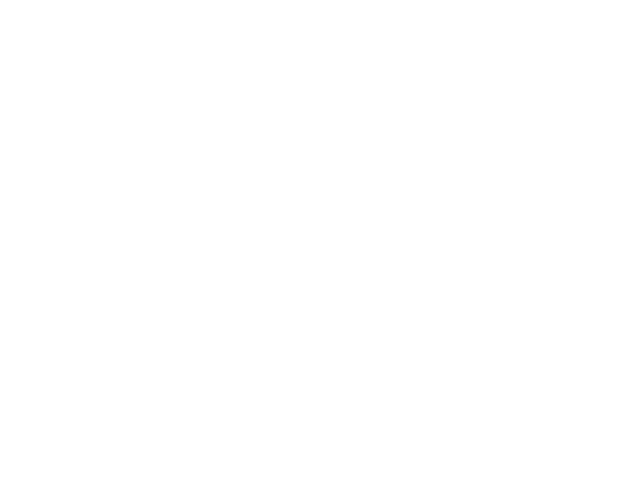

<IPython.core.display.Javascript object>


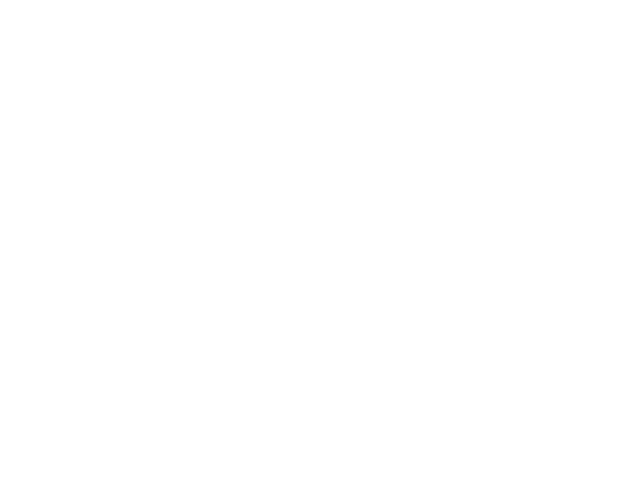

In [101]:
%matplotlib nbagg
now = train.next()
plt.figure()
plt.imshow(np.reshape(now[1][0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0],(480,640)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


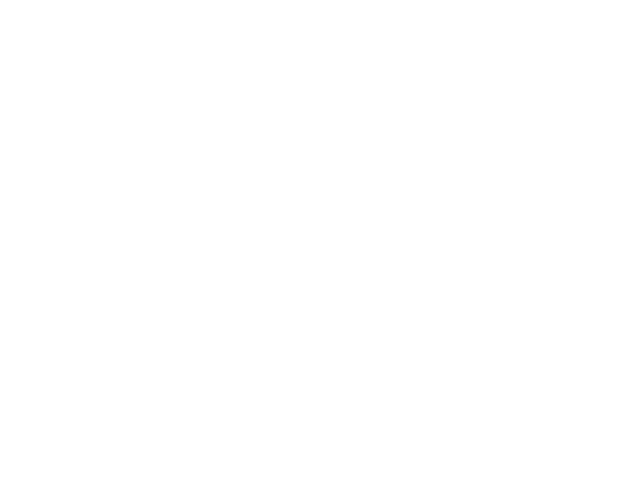

<IPython.core.display.Javascript object>


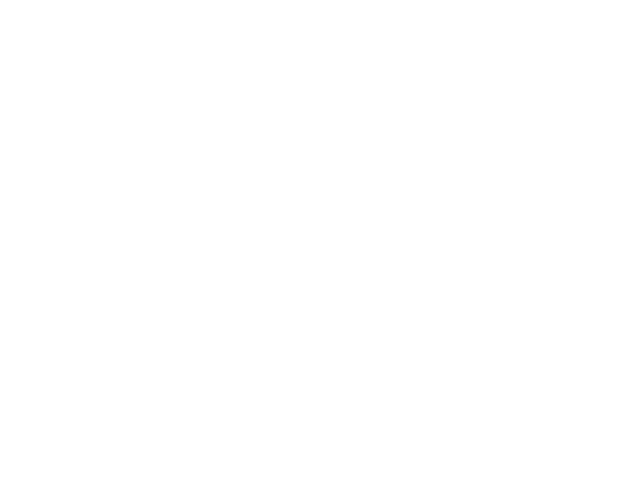

<IPython.core.display.Javascript object>


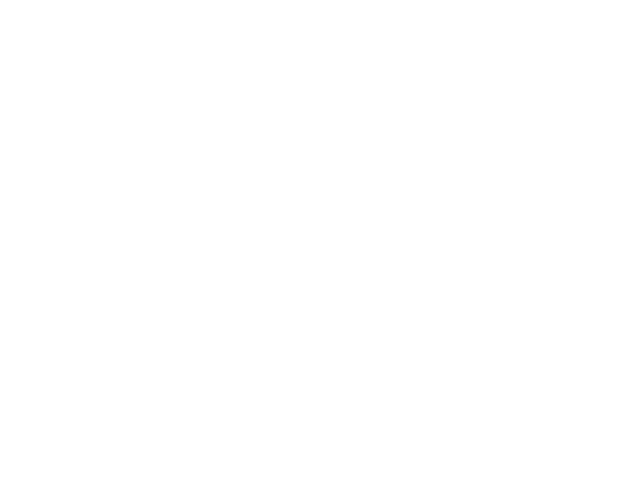

<IPython.core.display.Javascript object>


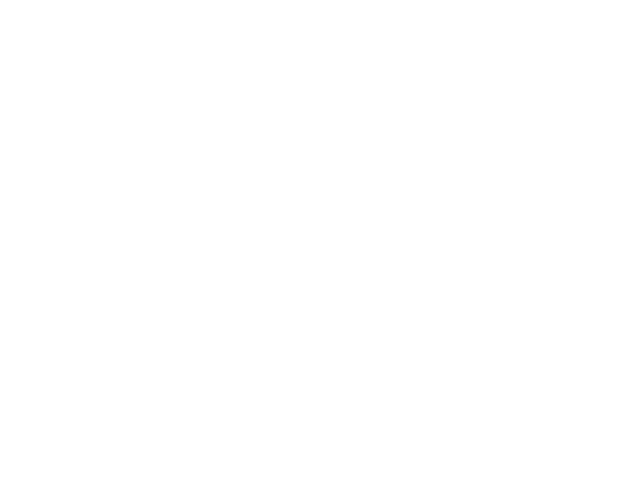

In [58]:
%matplotlib nbagg
now = gen.next()
plt.figure()
plt.imshow(np.reshape(now[1][0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,1:4],(480,640,3)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,4:],(480,640,3)))

In [102]:
img_height = 480 #check with old params
img_width = 640
inputs = Input((img_height, img_width,1))

In [129]:
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)


conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv5))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 480, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 480, 640, 4)  40          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 480, 640, 4)  148         conv2d_82[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 240, 320, 4)  0           conv2d_83[0][0]                  
__________________________________________________________________________________________________
conv2d_84 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Update

In [113]:
def network(input_image_tensor):
    def resnet_block_1(input_features, nb_features=16, nb_kernel_rows=3, nb_kernel_cols=3):

        y = Conv2D(nb_features, nb_kernel_cols, padding='same',data_format='channels_last')(input_features)
        y = Activation('relu')(y)
        y = Conv2D(nb_features, nb_kernel_rows, padding='same',data_format='channels_last')(y)

        y = add([input_features, y])
        return Activation('relu')(y)

    x = Conv2D(4, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)
    x = Conv2D(16, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)

    for _ in range(4):
        x = resnet_block_1(x)
        
    x = Conv2D(1, 1, padding='same', activation='sigmoid',data_format='channels_last')(x)

    
    model = Model(input = inputs, output = x)
    print model.summary()
    model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [104]:
model = network(inputs)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 480, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 480, 640, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 480, 640, 16) 2320        conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 480, 640, 16) 0           conv2d_73[0][0]                  
__________________________________________________________________________________________________
conv2d_74 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [107]:
batch_size = 8

In [108]:
from keras import backend as K
class Image_Saver(Callback):
    def on_train_begin(self,logs={}):
        self.var_y_pred = tf.placeholder(tf.float32, [FLAGS.batch_size, 480,640,1])
        #self.var_y_pred = tf.Variable(0., validate_shape=False)

    def on_batch_end(self, batch, logs={}):
            #callback = TensorBoard(log_path)
            #callback.set_model(model)
            
            print type(K.eval(self.model.outputs[0]))
            x=self.model.predict_on_batch(batch)
            writer = tf.summary.FileWriter('./logs1')
            writer.add_summary(tf.summary.image('input', x[0]))
save = Image_Saver()

In [275]:
model_checkpoint = ModelCheckpoint('net_depth_seg_v1.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs1', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
model.fit_generator(train, nb_epoch=1000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=1000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/1000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.1300 - acc: 0.9542
Epoch 00001: loss improved from inf to 0.12986, saving model to net_depth_seg_v1.hdf5
100/100 [==============================] - 82s 815ms/step - loss: 0.1299 - acc: 0.9543
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1317 - acc: 0.9539
Epoch 00002: loss did not improve
100/100 [==============================] - 81s 807ms/step - loss: 0.1322 - acc: 0.9538
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1332 - acc: 0.9542
Epoch 00003: loss did not improve
100/100 [==============================] - 80s 799ms/step - loss: 0.1331 - acc: 0.9542
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1350 - acc: 0.9526
Epoch 00004: loss did not improve
100/100 [==============================] - 81s 811ms/step - loss: 0.1348 - acc: 0.9527
Epoch 5/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1312 - acc: 0.9538
Epoch 00005:

Epoch 39/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1372 - acc: 0.9515
Epoch 00039: loss did not improve
100/100 [==============================] - 86s 856ms/step - loss: 0.1370 - acc: 0.9516
Epoch 40/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1248 - acc: 0.9563
Epoch 00040: loss improved from 0.12565 to 0.12463, saving model to net_depth_seg_v1.hdf5
100/100 [==============================] - 85s 846ms/step - loss: 0.1246 - acc: 0.9563
Epoch 41/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1317 - acc: 0.9537
Epoch 00041: loss did not improve
100/100 [==============================] - 87s 867ms/step - loss: 0.1314 - acc: 0.9538
Epoch 42/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1322 - acc: 0.9536
Epoch 00042: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.1320 - acc: 0.9536
Epoch 43/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1298 - ac

Epoch 77/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1272 - acc: 0.9552
Epoch 00077: loss did not improve
100/100 [==============================] - 84s 844ms/step - loss: 0.1272 - acc: 0.9552
Epoch 78/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1338 - acc: 0.9528
Epoch 00078: loss did not improve
100/100 [==============================] - 85s 848ms/step - loss: 0.1334 - acc: 0.9529
Epoch 79/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1304 - acc: 0.9539
Epoch 00079: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.1301 - acc: 0.9539
Epoch 80/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1279 - acc: 0.9552
Epoch 00080: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.1288 - acc: 0.9549
Epoch 81/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1322 - acc: 0.9530
Epoch 00081: loss did not improve
100/100 [===

Epoch 115/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1291 - acc: 0.9542
Epoch 00115: loss did not improve
100/100 [==============================] - 84s 844ms/step - loss: 0.1298 - acc: 0.9541
Epoch 116/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1340 - acc: 0.9528
Epoch 00116: loss did not improve
100/100 [==============================] - 84s 843ms/step - loss: 0.1336 - acc: 0.9529
Epoch 117/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1385 - acc: 0.9505
Epoch 00117: loss did not improve
100/100 [==============================] - 84s 844ms/step - loss: 0.1384 - acc: 0.9505
Epoch 118/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9533
Epoch 00118: loss did not improve
100/100 [==============================] - 85s 848ms/step - loss: 0.1313 - acc: 0.9534
Epoch 119/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1314 - acc: 0.9539
Epoch 00119: loss did not improve
100/100

Epoch 153/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1326 - acc: 0.9532
Epoch 00153: loss did not improve
100/100 [==============================] - 84s 841ms/step - loss: 0.1327 - acc: 0.9532
Epoch 154/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9565
Epoch 00154: loss improved from 0.12237 to 0.12165, saving model to net_depth_seg_v1.hdf5
100/100 [==============================] - 84s 843ms/step - loss: 0.1216 - acc: 0.9565
Epoch 155/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1311 - acc: 0.9540
Epoch 00155: loss did not improve
100/100 [==============================] - 85s 847ms/step - loss: 0.1309 - acc: 0.9540
Epoch 156/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9531
Epoch 00156: loss did not improve
100/100 [==============================] - 84s 841ms/step - loss: 0.1314 - acc: 0.9532
Epoch 157/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1258

Epoch 191/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1314 - acc: 0.9535
Epoch 00191: loss did not improve
100/100 [==============================] - 85s 851ms/step - loss: 0.1312 - acc: 0.9535
Epoch 192/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1218 - acc: 0.9565
Epoch 00192: loss improved from 0.12165 to 0.12156, saving model to net_depth_seg_v1.hdf5
100/100 [==============================] - 84s 840ms/step - loss: 0.1216 - acc: 0.9566
Epoch 193/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1275 - acc: 0.9539
Epoch 00193: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.1272 - acc: 0.9541
Epoch 194/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1310 - acc: 0.9534
Epoch 00194: loss did not improve
100/100 [==============================] - 84s 835ms/step - loss: 0.1309 - acc: 0.9534
Epoch 195/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1260

 99/100 [============================>.] - ETA: 0s - loss: 0.1261 - acc: 0.9553
Epoch 00228: loss did not improve
100/100 [==============================] - 85s 851ms/step - loss: 0.1263 - acc: 0.9552
Epoch 229/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1263 - acc: 0.9552
Epoch 00229: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.1261 - acc: 0.9553
Epoch 230/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1250 - acc: 0.9549
Epoch 00230: loss did not improve
100/100 [==============================] - 86s 859ms/step - loss: 0.1250 - acc: 0.9549
Epoch 231/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1266 - acc: 0.9546
Epoch 00231: loss did not improve
100/100 [==============================] - 85s 854ms/step - loss: 0.1263 - acc: 0.9547
Epoch 232/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9550
Epoch 00232: loss did not improve
100/100 [=============

Epoch 266/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9535
Epoch 00266: loss did not improve
100/100 [==============================] - 84s 845ms/step - loss: 0.1298 - acc: 0.9536
Epoch 267/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1279 - acc: 0.9537
Epoch 00267: loss did not improve
100/100 [==============================] - 83s 828ms/step - loss: 0.1277 - acc: 0.9538
Epoch 268/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1274 - acc: 0.9541
Epoch 00268: loss did not improve
100/100 [==============================] - 84s 842ms/step - loss: 0.1274 - acc: 0.9541
Epoch 269/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1254 - acc: 0.9552
Epoch 00269: loss did not improve
100/100 [==============================] - 85s 850ms/step - loss: 0.1254 - acc: 0.9552
Epoch 270/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1219 - acc: 0.9561
Epoch 00270: loss did not improve
100/100

Epoch 304/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1234 - acc: 0.9557
Epoch 00304: loss did not improve
100/100 [==============================] - 83s 832ms/step - loss: 0.1236 - acc: 0.9556
Epoch 305/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1280 - acc: 0.9544
Epoch 00305: loss did not improve
100/100 [==============================] - 84s 844ms/step - loss: 0.1281 - acc: 0.9544
Epoch 306/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1241 - acc: 0.9552
Epoch 00306: loss did not improve
100/100 [==============================] - 86s 855ms/step - loss: 0.1238 - acc: 0.9553
Epoch 307/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1268 - acc: 0.9541
Epoch 00307: loss did not improve
100/100 [==============================] - 83s 827ms/step - loss: 0.1269 - acc: 0.9541
Epoch 308/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1216 - acc: 0.9560
Epoch 00308: loss did not improve
100/100

Epoch 342/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1221 - acc: 0.9557
Epoch 00342: loss did not improve
100/100 [==============================] - 84s 843ms/step - loss: 0.1220 - acc: 0.9558
Epoch 343/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1220 - acc: 0.9557
Epoch 00343: loss did not improve
100/100 [==============================] - 84s 845ms/step - loss: 0.1217 - acc: 0.9558
Epoch 344/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9565
Epoch 00344: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.1190 - acc: 0.9566
Epoch 345/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1214 - acc: 0.9564
Epoch 00345: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.1215 - acc: 0.9563
Epoch 346/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1254 - acc: 0.9547
Epoch 00346: loss did not improve
100/100

Epoch 380/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1182 - acc: 0.9572
Epoch 00380: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.1181 - acc: 0.9572
Epoch 381/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1218 - acc: 0.9563
Epoch 00381: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.1218 - acc: 0.9563
Epoch 382/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1177 - acc: 0.9572
Epoch 00382: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.1178 - acc: 0.9572
Epoch 383/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1227 - acc: 0.9556
Epoch 00383: loss did not improve
100/100 [==============================] - 83s 833ms/step - loss: 0.1227 - acc: 0.9557
Epoch 384/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1241 - acc: 0.9550
Epoch 00384: loss did not improve
100/100

Epoch 418/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1202 - acc: 0.9563
Epoch 00418: loss did not improve
100/100 [==============================] - 81s 813ms/step - loss: 0.1204 - acc: 0.9562
Epoch 419/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1252 - acc: 0.9548
Epoch 00419: loss did not improve
100/100 [==============================] - 85s 852ms/step - loss: 0.1248 - acc: 0.9549
Epoch 420/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1255 - acc: 0.9547
Epoch 00420: loss did not improve
100/100 [==============================] - 85s 847ms/step - loss: 0.1252 - acc: 0.9548
Epoch 421/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1250 - acc: 0.9544
Epoch 00421: loss did not improve
100/100 [==============================] - 85s 850ms/step - loss: 0.1254 - acc: 0.9544
Epoch 422/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1222 - acc: 0.9558
Epoch 00422: loss did not improve
100/100

Epoch 455/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9575
Epoch 00455: loss did not improve
100/100 [==============================] - 84s 844ms/step - loss: 0.1180 - acc: 0.9575
Epoch 456/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1188 - acc: 0.9572
Epoch 00456: loss did not improve
100/100 [==============================] - 83s 832ms/step - loss: 0.1186 - acc: 0.9572
Epoch 457/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1248 - acc: 0.9545
Epoch 00457: loss did not improve
100/100 [==============================] - 84s 845ms/step - loss: 0.1247 - acc: 0.9545
Epoch 458/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1260 - acc: 0.9547
Epoch 00458: loss did not improve
100/100 [==============================] - 84s 844ms/step - loss: 0.1257 - acc: 0.9548
Epoch 459/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1237 - acc: 0.9552
Epoch 00459: loss did not improve
100/100

Epoch 493/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9563
Epoch 00493: loss did not improve
100/100 [==============================] - 85s 854ms/step - loss: 0.1220 - acc: 0.9561
Epoch 494/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1214 - acc: 0.9558
Epoch 00494: loss did not improve
100/100 [==============================] - 83s 833ms/step - loss: 0.1215 - acc: 0.9558
Epoch 495/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1238 - acc: 0.9552
Epoch 00495: loss did not improve
100/100 [==============================] - 84s 845ms/step - loss: 0.1237 - acc: 0.9552
Epoch 496/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1196 - acc: 0.9562
Epoch 00496: loss did not improve
100/100 [==============================] - 85s 852ms/step - loss: 0.1192 - acc: 0.9564
Epoch 497/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9550
Epoch 00497: loss did not improve
100/100

Epoch 531/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1237 - acc: 0.9550
Epoch 00531: loss did not improve
100/100 [==============================] - 84s 843ms/step - loss: 0.1237 - acc: 0.9550
Epoch 532/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1231 - acc: 0.9554
Epoch 00532: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.1227 - acc: 0.9555
Epoch 533/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1205 - acc: 0.9561
Epoch 00533: loss did not improve
100/100 [==============================] - 84s 843ms/step - loss: 0.1209 - acc: 0.9559
Epoch 534/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1250 - acc: 0.9544
Epoch 00534: loss did not improve
100/100 [==============================] - 84s 843ms/step - loss: 0.1251 - acc: 0.9544
Epoch 535/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1161 - acc: 0.9581
Epoch 00535: loss did not improve
100/100

Epoch 569/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1183 - acc: 0.9563
Epoch 00569: loss did not improve
100/100 [==============================] - 84s 845ms/step - loss: 0.1183 - acc: 0.9563
Epoch 570/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9577
Epoch 00570: loss did not improve
100/100 [==============================] - 85s 850ms/step - loss: 0.1152 - acc: 0.9577
Epoch 571/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1193 - acc: 0.9560
Epoch 00571: loss did not improve
100/100 [==============================] - 83s 833ms/step - loss: 0.1190 - acc: 0.9561
Epoch 572/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1184 - acc: 0.9569
Epoch 00572: loss did not improve
100/100 [==============================] - 85s 846ms/step - loss: 0.1182 - acc: 0.9570
Epoch 573/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1194 - acc: 0.9565
Epoch 00573: loss did not improve
100/100

Epoch 607/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1144 - acc: 0.9579
Epoch 00607: loss did not improve
100/100 [==============================] - 84s 835ms/step - loss: 0.1142 - acc: 0.9580
Epoch 608/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1230 - acc: 0.9546
Epoch 00608: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.1231 - acc: 0.9545
Epoch 609/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.9588
Epoch 00609: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.1128 - acc: 0.9588
Epoch 610/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1178 - acc: 0.9571
Epoch 00610: loss did not improve
100/100 [==============================] - 85s 847ms/step - loss: 0.1184 - acc: 0.9568
Epoch 611/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1174 - acc: 0.9567
Epoch 00611: loss did not improve
100/100

Epoch 645/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1151 - acc: 0.9578
Epoch 00645: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.1148 - acc: 0.9579
Epoch 646/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1193 - acc: 0.9560
Epoch 00646: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.1189 - acc: 0.9561
Epoch 647/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1182 - acc: 0.9565
Epoch 00647: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.1181 - acc: 0.9566
Epoch 648/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1207 - acc: 0.9555
Epoch 00648: loss did not improve
100/100 [==============================] - 84s 844ms/step - loss: 0.1212 - acc: 0.9553
Epoch 649/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1158 - acc: 0.9580
Epoch 00649: loss did not improve
100/100

Epoch 683/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1190 - acc: 0.9566
Epoch 00683: loss did not improve
100/100 [==============================] - 85s 847ms/step - loss: 0.1187 - acc: 0.9568
Epoch 684/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1177 - acc: 0.9567
Epoch 00684: loss did not improve
100/100 [==============================] - 85s 850ms/step - loss: 0.1183 - acc: 0.9565
Epoch 685/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1234 - acc: 0.9546
Epoch 00685: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.1232 - acc: 0.9546
Epoch 686/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1227 - acc: 0.9551
Epoch 00686: loss did not improve
100/100 [==============================] - 85s 849ms/step - loss: 0.1227 - acc: 0.9552
Epoch 687/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1190 - acc: 0.9558
Epoch 00687: loss did not improve
100/100

Epoch 721/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1151 - acc: 0.9574
Epoch 00721: loss did not improve
100/100 [==============================] - 84s 843ms/step - loss: 0.1150 - acc: 0.9574
Epoch 722/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1196 - acc: 0.9563
Epoch 00722: loss did not improve
100/100 [==============================] - 84s 844ms/step - loss: 0.1194 - acc: 0.9564
Epoch 723/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1151 - acc: 0.9575
Epoch 00723: loss did not improve
100/100 [==============================] - 85s 847ms/step - loss: 0.1152 - acc: 0.9575
Epoch 724/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1155 - acc: 0.9576
Epoch 00724: loss did not improve
100/100 [==============================] - 84s 844ms/step - loss: 0.1153 - acc: 0.9577
Epoch 725/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1211 - acc: 0.9557
Epoch 00725: loss did not improve
100/100

Epoch 759/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.9583
Epoch 00759: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.1131 - acc: 0.9581
Epoch 760/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1202 - acc: 0.9561
Epoch 00760: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.1199 - acc: 0.9562
Epoch 761/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1140 - acc: 0.9579
Epoch 00761: loss did not improve
100/100 [==============================] - 85s 851ms/step - loss: 0.1138 - acc: 0.9580
Epoch 762/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1148 - acc: 0.9574
Epoch 00762: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.1148 - acc: 0.9574
Epoch 763/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1219 - acc: 0.9551
Epoch 00763: loss did not improve
100/100

Epoch 797/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1186 - acc: 0.9565
Epoch 00797: loss did not improve
100/100 [==============================] - 85s 855ms/step - loss: 0.1185 - acc: 0.9566
Epoch 798/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1122 - acc: 0.9589
Epoch 00798: loss did not improve
100/100 [==============================] - 85s 848ms/step - loss: 0.1125 - acc: 0.9587
Epoch 799/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1145 - acc: 0.9574
Epoch 00799: loss did not improve
100/100 [==============================] - 86s 855ms/step - loss: 0.1145 - acc: 0.9574
Epoch 800/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1175 - acc: 0.9564
Epoch 00800: loss did not improve
100/100 [==============================] - 84s 841ms/step - loss: 0.1180 - acc: 0.9562
Epoch 801/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1166 - acc: 0.9571
Epoch 00801: loss did not improve
100/100

Epoch 835/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1225 - acc: 0.9548
Epoch 00835: loss did not improve
100/100 [==============================] - 85s 850ms/step - loss: 0.1226 - acc: 0.9547
Epoch 836/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9568
Epoch 00836: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.1159 - acc: 0.9568
Epoch 837/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1200 - acc: 0.9557
Epoch 00837: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.1197 - acc: 0.9558
Epoch 838/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9571
Epoch 00838: loss did not improve
100/100 [==============================] - 85s 855ms/step - loss: 0.1162 - acc: 0.9571
Epoch 839/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.9582
Epoch 00839: loss did not improve
100/100

Epoch 873/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9593
Epoch 00873: loss did not improve
100/100 [==============================] - 83s 830ms/step - loss: 0.1103 - acc: 0.9593
Epoch 874/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1205 - acc: 0.9559
Epoch 00874: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.1206 - acc: 0.9558
Epoch 875/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1176 - acc: 0.9565
Epoch 00875: loss did not improve
100/100 [==============================] - 86s 855ms/step - loss: 0.1177 - acc: 0.9565
Epoch 876/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1154 - acc: 0.9573
Epoch 00876: loss did not improve
100/100 [==============================] - 85s 848ms/step - loss: 0.1152 - acc: 0.9573
Epoch 877/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1155 - acc: 0.9571
Epoch 00877: loss did not improve
100/100

Epoch 911/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9559
Epoch 00911: loss did not improve
100/100 [==============================] - 86s 859ms/step - loss: 0.1190 - acc: 0.9560
Epoch 912/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1132 - acc: 0.9579
Epoch 00912: loss did not improve
100/100 [==============================] - 84s 835ms/step - loss: 0.1136 - acc: 0.9577
Epoch 913/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9584
Epoch 00913: loss did not improve
100/100 [==============================] - 85s 847ms/step - loss: 0.1112 - acc: 0.9585
Epoch 914/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1146 - acc: 0.9574
Epoch 00914: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.1146 - acc: 0.9574
Epoch 915/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1135 - acc: 0.9580
Epoch 00915: loss did not improve
100/100

Epoch 949/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1131 - acc: 0.9581
Epoch 00949: loss did not improve
100/100 [==============================] - 85s 849ms/step - loss: 0.1132 - acc: 0.9580
Epoch 950/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1122 - acc: 0.9586
Epoch 00950: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.1125 - acc: 0.9585
Epoch 951/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1098 - acc: 0.9591
Epoch 00951: loss did not improve
100/100 [==============================] - 85s 847ms/step - loss: 0.1100 - acc: 0.9590
Epoch 952/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1143 - acc: 0.9575
Epoch 00952: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.1140 - acc: 0.9576
Epoch 953/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1152 - acc: 0.9572
Epoch 00953: loss did not improve
100/100

Epoch 987/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1122 - acc: 0.9583
Epoch 00987: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.1121 - acc: 0.9584
Epoch 988/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1158 - acc: 0.9571
Epoch 00988: loss did not improve
100/100 [==============================] - 85s 852ms/step - loss: 0.1159 - acc: 0.9571
Epoch 989/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9570
Epoch 00989: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.1154 - acc: 0.9570
Epoch 990/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1185 - acc: 0.9561
Epoch 00990: loss did not improve
100/100 [==============================] - 86s 861ms/step - loss: 0.1187 - acc: 0.9561
Epoch 991/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1173 - acc: 0.9564
Epoch 00991: loss did not improve
100/100

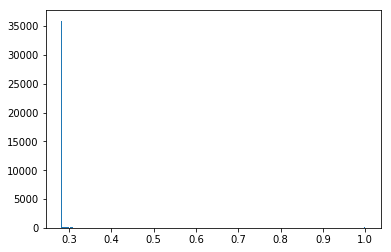

In [162]:
plt.figure()
plt.hist(img.ravel(), bins=256)
plt.show()

In [305]:
test = train.next()
X_Test = test[0][0:1]

Y_Test = test[1][0:1]
imgs_mask_test = model.predict_on_batch(X_Test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


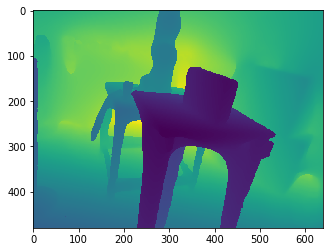

In [306]:
%matplotlib inline
img = np.reshape(X_Test[0],(img_height,img_width,))
plt.imshow(img)

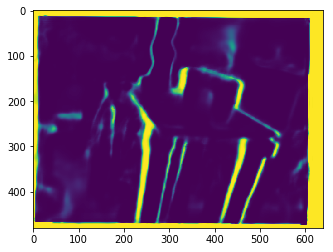

In [307]:
%matplotlib inline
img = np.reshape(imgs_mask_test[0],(img_height,img_width))
plt.imshow(img)

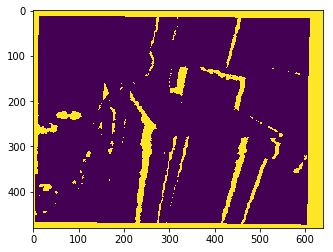

In [308]:
%matplotlib inline
img1 = np.reshape(Y_Test[0],(img_height,img_width))
plt.imshow(img1)

In [ ]:
img1 = np.copy(img)
img1[img1>.3] =1
plt.imshow(img1)